In [2]:
import os
import sys
import copy
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras.api._v2.keras as keras
import keras.backend as K
from keras.optimizers.legacy import Adam
from keras.optimizers import SGD
from keras import callbacks
from keras.models import Model
from keras.layers import Layer, Dense, Input, Activation, Lambda, BatchNormalization, Conv1D, SpatialDropout1D, add, GlobalAveragePooling1D
from keras.activations import sigmoid
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [3]:
# Load pre-processed audio-only data
data = np.load("./MFCC/IEMOCAP.npy",allow_pickle=True).item()
x_source = data["x"]
y_source = data["y"]
# Print shape of data
print("x shape:", x_source.shape)
print("y shape:", y_source.shape)
CLASS_LABELS = ("angry", "happy", "neutral", "sad")

x shape: (5531, 606, 39)
y shape: (5531, 4)


In [9]:
# TIM-Net Model

# Define Common Model class
class Common_Model(object):

    def __init__(self, save_path: str = '', name: str = 'Not Specified'):
        self.model = None
        self.trained = False 

    def train(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError()

    def predict(self, samples):
        raise NotImplementedError()
        

    def predict_proba(self, samples):
        if not self.trained:
            sys.stderr.write("No Model.")
            sys.exit(-1)
        return self.model.predict_proba(samples)

    def save_model(self, model_name: str):
        raise NotImplementedError()


def Temporal_Aware_Block(x, s, i, activation, nb_filters, kernel_size, dropout_rate=0, name=''):

    original_x = x
    #1.1
    conv_1_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(x)
    conv_1_1 = BatchNormalization(trainable=True,axis=-1)(conv_1_1)
    conv_1_1 =  Activation(activation)(conv_1_1)
    output_1_1 =  SpatialDropout1D(dropout_rate)(conv_1_1)

    # 2.1
    conv_2_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(output_1_1)
    conv_2_1 = BatchNormalization(trainable=True,axis=-1)(conv_2_1)
    conv_2_1 = Activation(activation)(conv_2_1)
    output_2_1 =  SpatialDropout1D(dropout_rate)(conv_2_1)
    
    if original_x.shape[-1] != output_2_1.shape[-1]:
        original_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(original_x)
        
    output_2_1 = Lambda(sigmoid)(output_2_1)
    F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
    return F_x


class TIMNET:
    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation = "relu",
                 dropout_rate=0.1,
                 return_sequences=True,
                 name='TIMNET'):
        self.name = name
        self.return_sequences = return_sequences
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        self.supports_masking = True
        self.mask_value=0.

        if not isinstance(nb_filters, int):
            raise Exception()

    def __call__(self, inputs, mask=None):
        if self.dilations is None:
            self.dilations = 8
        forward = inputs
        backward = K.reverse(inputs,axes=1)
        
        print("Input Shape=",inputs.shape)
        forward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(forward)
        backward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(backward)

        final_skip_connection = []
        
        skip_out_forward = forward_convd
        skip_out_backward = backward_convd
        
        for s in range(self.nb_stacks):
            for i in [2 ** i for i in range(self.dilations)]:
                skip_out_forward = Temporal_Aware_Block(skip_out_forward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                skip_out_backward = Temporal_Aware_Block(skip_out_backward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                
                temp_skip = add([skip_out_forward, skip_out_backward],name = "biadd_"+str(i))
                temp_skip=GlobalAveragePooling1D()(temp_skip)
                temp_skip=tf.expand_dims(temp_skip, axis=1)
                final_skip_connection.append(temp_skip)

        output_2 = final_skip_connection[0]
        for i,item in enumerate(final_skip_connection):
            if i==0:
                continue
            output_2 = K.concatenate([output_2,item],axis=-2)
        x = output_2

        return x

def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

class WeightLayer(Layer):
    def __init__(self, **kwargs):
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1],1),
                                      initializer='uniform',
                                      trainable=True)  
        super(WeightLayer, self).build(input_shape)  
 
    def call(self, x):
        tempx = tf.transpose(x,[0,2,1])
        x = K.dot(tempx,self.kernel)
        x = tf.squeeze(x,axis=-1)
        return  x
 
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])

def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

class TIMNET_Model(Common_Model):
    def __init__(self, args, input_shape, class_label, **params):
        super(TIMNET_Model,self).__init__(**params)
        self.args = args
        self.data_shape = input_shape
        self.num_classes = len(class_label)
        self.class_label = class_label
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
    
    def create_model(self):
        self.inputs=Input(shape = (self.data_shape[0],self.data_shape[1]))
        self.multi_decision = TIMNET(nb_filters=self.args.filter_size,
                                kernel_size=self.args.kernel_size, 
                                nb_stacks=self.args.stack_size,
                                dilations=self.args.dilation_size,
                                dropout_rate=self.args.dropout,
                                activation = self.args.activation,
                                return_sequences=True, 
                                name='TIMNET')(self.inputs)

        self.decision = WeightLayer()(self.multi_decision)
        self.predictions = Dense(self.num_classes, activation='softmax')(self.decision)
        self.model = Model(inputs = self.inputs, outputs = self.predictions)
        
        self.model.compile(loss = "categorical_crossentropy",
                           optimizer =Adam(learning_rate=self.args.lr, beta_1=self.args.beta1, beta_2=self.args.beta2, epsilon=1e-8),
                           metrics = ['accuracy'])
        print("TIMNet Model creation completed")
        
    def train(self, x, y):
        label_mapping = {'hap': 0, 'sad': 1, 'neu': 2, 'ang': 3, 'exc': 4, 'fru': 5}
        reverse_mapping = {v: k for k, v in label_mapping.items()}

        filepath = self.args.model_path
        resultpath = self.args.result_path

        os.makedirs(filepath, exist_ok=True)
        os.makedirs(resultpath, exist_ok=True)

        now = datetime.datetime.now()
        now_time = datetime.datetime.strftime(now,'%Y-%m-%d_%H-%M-%S')

        total_accuracy = 0
        total_loss = 0
        total_precision = []
        total_recall = []
        total_f1 = []

        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        
        fold_counter = 0
        
        for train_index, test_index in kfold.split(x):
            self.create_model()
            y_train_smoothed = smooth_labels(y[train_index].copy(), 0.1)
            
            folder_address = os.path.join(filepath, f"{self.args.data}_{self.args.random_seed}_{now_time}")
            os.makedirs(folder_address, exist_ok=True)
            
            weight_path = os.path.join(folder_address, f"{self.args.split_fold}-fold_weights_best_{fold_counter+1}.hdf5")
            checkpoint = ModelCheckpoint(weight_path, verbose=1, save_weights_only=True, save_best_only=True)

            self.model.fit(x[train_index], y_train_smoothed, validation_data=(x[test_index], y[test_index]),
                            batch_size=self.args.batch_size, epochs=self.args.epoch, verbose=1, callbacks=[checkpoint])
            
            self.model.load_weights(weight_path)
            eval_result = self.model.evaluate(x[test_index], y[test_index], verbose=0)
            
            total_loss += eval_result[0]
            total_accuracy += eval_result[1]

            # Generate predictions for the current fold's test set
            y_pred = self.model.predict(x[test_index])
            y_true = y[test_index]
            y_pred_classes = np.argmax(y_pred, axis=-1).flatten()  # Convert softmax outputs to class indices and flatten
            y_true_classes = np.argmax(y[test_index], axis=-1).flatten()  # Correctly using y[test_index] to flatten the true labels

            # Generate the classification report for the current fold
            try:
                print(classification_report(y_true_classes, y_pred_classes, target_names=[reverse_mapping[i] for i in range(len(label_mapping))]))
            except Exception as e:
                print(f"Error generating classification report: {e}")

            try:
                precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
                total_precision.append(precision)
                total_recall.append(recall)
                total_f1.append(f1)
            except Exception as e:
                print(f"Error generating precision, recall, and f1-score: {e}")

            fold_counter += 1

        avg_accuracy = total_accuracy / self.args.split_fold
        avg_loss = total_loss / self.args.split_fold
        print(f"Average accuracy over {self.args.split_fold} folds: {avg_accuracy}")
        print(f"Average loss over {self.args.split_fold} folds: {avg_loss}")
        avg_precision = np.mean(total_precision)
        avg_recall = np.mean(total_recall)
        avg_f1 = np.mean(total_f1)

        print(f"Average Precision: {avg_precision}")
        print(f"Average Recall: {avg_recall}")
        print(f"Average F1-Score: {avg_f1}")

        # Cleanup
        K.clear_session()
    
    def test(self, x, y, path):
        i = 1
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        all_metrics = []
        x_feats = []
        y_labels = []

        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path=path + '/' + str(self.args.split_fold) + "-fold_weights_best_" + str(i) + ".hdf5"
            # self.model.fit(x[train], y[train],validation_data=(x[test],  y[test]),batch_size = 64,epochs = 0,verbose=0)
            self.model.load_weights(weight_path)#+source_name+'_single_best.hdf5')
            best_eva_list = self.model.evaluate(x[test],  y[test])
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1

            # Predict and extract features
            y_pred_best = self.model.predict(x[test])
            caps_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer(index=-2).output)
            feature_source = caps_layer_model.predict(x[test])
            x_feats.append(feature_source)
            y_labels.append(y[test])

            # Save confusion matrix and classification report
            self.matrix.append(confusion_matrix(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1)))
            report = classification_report(np.argmax(y[test], axis=1), np.argmax(y_pred_best, axis=1), target_names=self.class_label, output_dict=True)
            all_metrics.append(report)
            print(classification_report(np.argmax(y[test], axis=1), np.argmax(y_pred_best, axis=1), target_names=self.class_label))
            
        print("Average ACC:",avg_accuracy/self.args.split_fold)
        self.acc = avg_accuracy/self.args.split_fold
        avg_loss /= i - 1
        avg_precision = np.mean([metrics['macro avg']['precision'] for metrics in all_metrics])
        avg_recall = np.mean([metrics['macro avg']['recall'] for metrics in all_metrics])
        avg_f1_score = np.mean([metrics['macro avg']['f1-score'] for metrics in all_metrics])

        print(f"Average Loss: {avg_loss}")
        print(f"Average Accuracy: {self.acc}")
        print(f"Average Precision: {avg_precision}")
        print(f"Average Recall: {avg_recall}")
        print(f"Average F1-Score: {avg_f1_score}")
        return x_feats, y_labels

        


In [5]:
# Define and set parameters
class Args:
    def __init__(self, mode, data='IEMOCAP', split_fold=5, random_seed=16, epoch=50, test_path='./Test_Models/IEMOCAP_16'):
        self.mode = mode
        self.data = data
        self.split_fold = split_fold
        self.random_seed = random_seed
        self.epoch = epoch
        self.gpu = 0
        self.model_path = './Models/'
        self.result_path = './Results/'
        self.test_path = test_path
        self.lr = 0.001
        self.beta1 = 0.93
        self.beta2 = 0.98
        self.batch_size = 64
        self.dropout = 0.1
        self.activation = 'relu'
        self.filter_size = 39
        self.dilation_size = 8 
        self.kernel_size = 2
        self.stack_size = 1


In [ ]:
# Train the model
args_train = Args(mode="train")
model = TIMNET_Model(args=args_train, input_shape=x_source.shape[1:], class_label=CLASS_LABELS)
model.train(x_source, y_source)

In [11]:
# Test the model
args_test = Args(mode="test", test_path='./Models/IEMOCAP_16_2024-03-08_11-13-15')
model = TIMNET_Model(args=args_test, input_shape=x_source.shape[1:], class_label=CLASS_LABELS)
model.test(x_source, y_source, path=args_test.test_path)

Input Shape= (None, 606, 39)
TIMNet Model creation completed


2024-03-12 20:00:22.120764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 12s 260ms/step - loss: 0.9265 - accuracy: 0.6260
1_Model evaluation:  [0.9264979958534241, 0.6260162591934204]    Now ACC: 62.6


2024-03-12 20:00:33.762466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 12s 240ms/step


2024-03-12 20:00:45.873154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 12s 251ms/step
              precision    recall  f1-score   support

       angry       0.71      0.73      0.72       239
       happy       0.77      0.41      0.54       339
     neutral       0.56      0.69      0.62       331
         sad       0.55      0.76      0.64       198

    accuracy                           0.63      1107
   macro avg       0.65      0.65      0.63      1107
weighted avg       0.66      0.63      0.62      1107

Input Shape= (None, 606, 39)
TIMNet Model creation completed


2024-03-12 20:00:59.124663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 14s 311ms/step - loss: 0.9886 - accuracy: 0.5741
2_Model evaluation:  [0.9885936975479126, 0.5741410255432129]    Now ACC: 60.01


2024-03-12 20:01:12.752423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 13s 288ms/step


2024-03-12 20:01:26.199761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 15s 293ms/step
              precision    recall  f1-score   support

       angry       0.64      0.75      0.69       217
       happy       0.73      0.45      0.56       336
     neutral       0.47      0.79      0.59       335
         sad       0.71      0.25      0.37       218

    accuracy                           0.57      1106
   macro avg       0.64      0.56      0.55      1106
weighted avg       0.63      0.57      0.56      1106

Input Shape= (None, 606, 39)
TIMNet Model creation completed


2024-03-12 20:01:41.992483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 14s 304ms/step - loss: 0.9367 - accuracy: 0.6329
3_Model evaluation:  [0.9366781711578369, 0.6329113841056824]    Now ACC: 61.10333333333333


2024-03-12 20:01:56.045346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 15s 303ms/step


2024-03-12 20:02:11.137434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 14s 270ms/step
              precision    recall  f1-score   support

       angry       0.86      0.47      0.61       233
       happy       0.68      0.53      0.60       333
     neutral       0.54      0.81      0.65       333
         sad       0.67      0.69      0.68       207

    accuracy                           0.63      1106
   macro avg       0.69      0.63      0.63      1106
weighted avg       0.67      0.63      0.63      1106

Input Shape= (None, 606, 39)
TIMNet Model creation completed


2024-03-12 20:02:33.289827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 22s 324ms/step - loss: 3.8492 - accuracy: 0.4575
4_Model evaluation:  [3.8491547107696533, 0.4575045108795166]    Now ACC: 57.265


2024-03-12 20:02:49.343455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 15s 321ms/step


2024-03-12 20:03:05.138274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 15s 305ms/step
              precision    recall  f1-score   support

       angry       0.89      0.34      0.50       206
       happy       0.36      0.93      0.52       321
     neutral       1.00      0.00      0.01       338
         sad       0.67      0.56      0.61       241

    accuracy                           0.46      1106
   macro avg       0.73      0.46      0.41      1106
weighted avg       0.72      0.46      0.38      1106

Input Shape= (None, 606, 39)
TIMNet Model creation completed


2024-03-12 20:03:21.661483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 18s 377ms/step - loss: 0.8518 - accuracy: 0.6618
5_Model evaluation:  [0.8517801761627197, 0.6618444919586182]    Now ACC: 59.048


2024-03-12 20:03:39.415255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 19s 399ms/step


2024-03-12 20:03:58.264884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 20s 375ms/step
              precision    recall  f1-score   support

       angry       0.65      0.81      0.72       208
       happy       0.82      0.41      0.55       307
     neutral       0.59      0.78      0.67       371
         sad       0.73      0.67      0.70       220

    accuracy                           0.66      1106
   macro avg       0.70      0.67      0.66      1106
weighted avg       0.69      0.66      0.65      1106

Average ACC: 0.5904835343360901
Average Loss: 1.5105409502983094
Average Accuracy: 0.5904835343360901
Average Precision: 0.6798576872677939
Average Recall: 0.5928196142167792
Average F1-Score: 0.5766427027065326


([array([[-0.09415281,  0.2816987 , -0.08230273, ...,  0.80194163,
           0.34453133,  0.09030837],
         [ 0.04952177,  0.2376175 , -0.00700203, ..., -0.301638  ,
           0.15649363, -0.08379543],
         [ 0.18336776,  0.3999239 , -0.05506032, ...,  0.03790897,
           0.07963908, -0.45834166],
         ...,
         [ 0.58902335, -0.12620223, -0.1916033 , ..., -0.4098872 ,
           0.1426087 , -0.23450506],
         [ 0.15683413, -0.8893722 , -0.07984397, ..., -3.5773897 ,
           0.47785825,  0.25450313],
         [ 0.18292552, -0.10119823, -0.07814464, ...,  0.03336895,
           0.1191507 , -0.08173478]], dtype=float32),
  array([[-0.03938535, -0.03730422, -0.01228315, ..., -0.05101323,
          -0.41557917, -0.48843098],
         [-0.6391901 , -0.15676546, -0.21929765, ...,  0.69846463,
          -0.10090506, -0.12464249],
         [-0.2395438 , -0.00909469,  0.01300383, ...,  0.15188313,
          -0.4998518 , -0.22258866],
         ...,
         [-0.039821

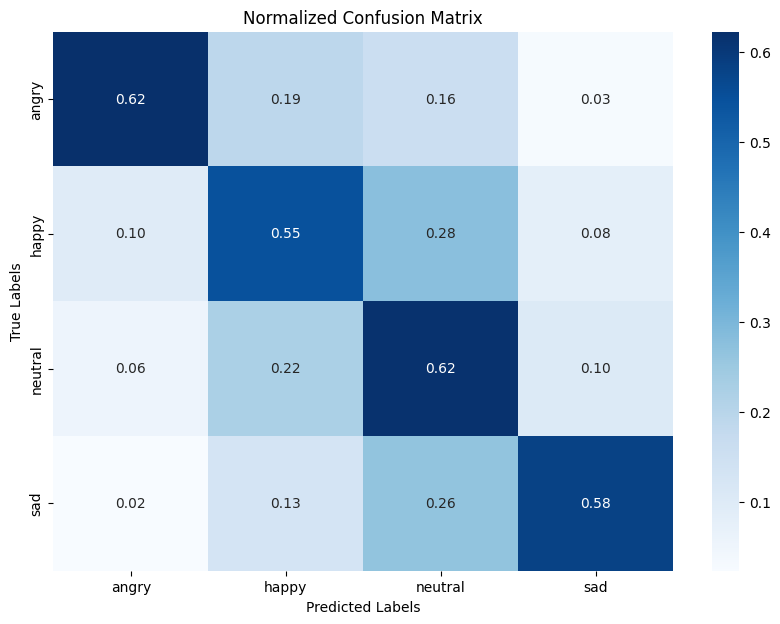

In [12]:
# Plot aggregated and normalized confusion matrix

aggregated_cm = np.sum(model.matrix, axis=0)
normalized_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()